In [1]:
import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 
%matplotlib inline
from autograd import grad
from numba import jit

In [2]:
# Workspace
"""
Here should be defined parameters of approximation:
– number of columns in model matrix (num_col)
– number of points using for approximation (num_points)
– dimension of the model (dim)
– bounds of domain (l_bound, u_bound)
– function to be approximated (def rhs(points))
"""
num_col = 50
num_points = 54
dim = 2

log_det.num_col = num_col # this is a global variable in module log_det
log_det.dim = dim         # this is a global variable in module log_det

assert num_col <= num_points, '! num_points < num_col !'

l_bound = -3.
u_bound = 3.

p = l_bound + (u_bound - l_bound)*np.random.rand(num_points, dim)
x_0 = p.T.ravel() # starting point of GD
bnds = tuple((l_bound, u_bound) for i in np.zeros(dim*num_points))

def rhs(points):
    return 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))# + (points[:,2]**2)/2.)) # Gaussian
    #return (1 - points[:,0])**2 + 100*(points[:,1] - points[:,0]**2)**2 # Rosenbrock
    #return (np.sin((points[:,0]**2)/2. - (points[:,1]**2)/4. + 3) * np.cos(2*points[:,0] + 1 - np.exp(points[:,1]))) # Trigonometric 

print('Max degree of expansion term = ', np.max(gen.indeces_K_cut(dim, num_col)))

('Max degree of expansion term = ', 8)


In [3]:
# optimization part (BFGS)
# %time res = optimize.fmin_l_bfgs_b(lambda x: log_det.loss_func(x), x_0, fprime = log_det.grad, factr = 10.0, bounds = bnds)

In [4]:
# check of the correctness of analytical gradient calculation
epsilon = 1e-5
print optimize.check_grad(log_det.loss_func, log_det.grad, x_0, epsilon=epsilon)
print optimize.check_grad(log_det.loss_func, grad(log_det.loss_func), x_0, epsilon=epsilon)

0.00130189688428
0.0013018895798


In [7]:
# approximation error (infinity norm) and comparison with MaxVol
M_gd = np.split(gen.GenMat(num_col, np.stack(np.split(res[0].T.ravel(),dim),1), poly = gen.cheb, poly_diff = gen.cheb_diff), dim + 1)[0]
c_gd = LA.solve(np.dot(M_gd.T, M_gd), np.dot(M_gd.T, rhs(np.stack(np.split(res[0].T.ravel(),dim),1))))

test = l_bound + (u_bound - l_bound)*np.random.rand(100000, dim)

M = np.split(gen.GenMat(num_col, test, poly = gen.cheb, poly_diff = gen.cheb_diff), dim + 1)[0]

print("GD error = ", LA.norm(rhs(test) - np.dot(M, c_gd), np.inf) / LA.norm(rhs(test), np.inf), "\n")

row_indx,_ = rect_maxvol(M, tol = 1.01, minK = num_points, maxK = num_points)
c_maxvol = LA.solve(np.dot(M[row_indx].T, M[row_indx]), np.dot(M[row_indx].T, rhs(test[row_indx])))

print("MaxVol error = ", LA.norm(rhs(test) - np.dot(M, c_maxvol), np.inf) / LA.norm(rhs(test), np.inf), "\n")

NameError: name 'res' is not defined

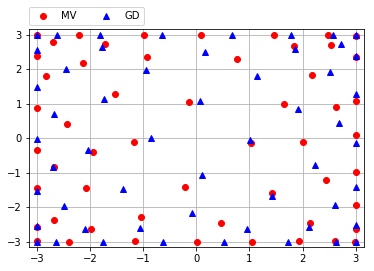

In [19]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(M_gd[:,1],M_gd[:,2], 'b^', label = "GD")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
plt.grid(True)
plt.show()

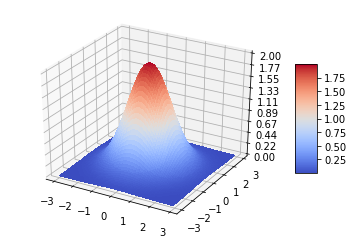

In [20]:
# visualization of approximated function 
fig = plt.figure()
ax = fig.gca(projection='3d')

# make data
X = np.arange(l_bound, u_bound, 0.08)
Y = np.arange(l_bound, u_bound, 0.08)
X, Y = np.meshgrid(X, Y)

Z = 2*np.exp(-((X**2)/2. + (Y**2)/2.))

# plot the surface
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.03, antialiased=False)

# customize the z axis
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Speed of d/dx

In [3]:
num = 100
xx = l_bound + (u_bound - l_bound)*np.random.rand(num, num_points*dim)
# g = grad(log_det.loss_func)
grad_f = grad(log_det.loss_func)
# grad_f = jit(g)

In [8]:
%%time
for e in xx:
    grad_f(e)

CPU times: user 5.29 s, sys: 29.9 ms, total: 5.32 s
Wall time: 5.32 s


In [9]:
%%time
for e in xx:
    log_det.grad(e)

CPU times: user 1.37 s, sys: 14.8 ms, total: 1.38 s
Wall time: 1.38 s
